In [1]:
from gptopt.optim.linop import *
from gptopt.optim.least_squares_torchmin import *
from gptopt.optim.attn_kq import * 
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )  
\end{aligned}
$$


In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 1000

betas = [ 1e-3, 5e-4, 1e-4]

#  $m=n=50$

In [20]:
m = n = 50
A2, A1, G1, G2, A2_np, A1_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=1, std2=1, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)
beta = 0.01

A_linop = attn_linop_from_matrices(A1, A2)
Grad = torch.cat([G1, G2], dim=0)
lamb_max = A_linop.fro_norm

mu_reg = 0

print(f"{lamb_max=:.4e}")

lamb_max=7.1365e+01


In [21]:
Z_star1, Z_star2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A2_np, A1_np, beta, mu=mu_reg, verbose=False)
Z_star = np.concatenate([Z_star1, Z_star2], axis=0)

In [22]:
Y_star_torch = torch.tensor(Y_star, dtype=A1.dtype, device=device)
Z_star_torch = torch.tensor(Z_star, dtype=A2.dtype, device=device) 
pd_residuals_max_ball_linop(A_linop, Y_star_torch, Z_star_torch, Grad, beta, mu_reg)

(1.411057382938452e-07,
 2.822114765876904e-07,
 1.5151370007515652e-06,
 1.1515448198157101e-07)

In [23]:
Y0, res_lsmr_y, itn_y = solve_lsmr_Y_lstsq(A_linop, Grad)
Z0, res_lsmr_z, itn_z = solve_lsmr_Z_lstsq(A_linop, beta, Y0)

print(f"{res_lsmr_y=:.4e}, {res_lsmr_z=:.4e}, {itn_y=}, {itn_z=}")
pd_residuals_max_ball_linop(A_linop, Y0, Z0, Grad, beta, mu_reg)

res_lsmr_y=2.2194e-05, res_lsmr_z=4.2017e-05, itn_y=370, itn_z=380


(0.9999997711181641,
 1.9999995422363281,
 0.00029201852157711983,
 2.219419205296753e-05)

In [24]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [25]:
func_obj = lambda Z: (Grad * Z).sum().item()  
func_constr_viol = lambda Z: max(torch.max(torch.abs(A_linop.mv(Z))).item() - beta, 0) / beta

In [26]:
print(
    f"{f_star=:.4e}, "
    f"{func_obj(Z_star_torch)}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(Z_star_torch)}"
) 

f_star=-5.0516e-01, -0.5051552057266235, 
cvxpy constraint violation: 8.158385753423425e-07


In [27]:
residuals = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, beta, mu_reg, f_star=f_star, 
                            stopping=False, max_iter=1000, eps_abs=1e-5)

Method                 Obj          Viol
----------------------------------------
pdhg          -5.000700e-01  9.675719e-01
rehpdhg       -5.638310e-01  3.684068e-01
pdhg ds       -4.998128e-01  7.049674e-01
rehpdhg ds    -5.716460e-01  4.319553e-01
ada rehpdhg   -5.051122e-01  1.741683e-02
ada rehpdhg ds  -5.051218e-01  1.200473e-02


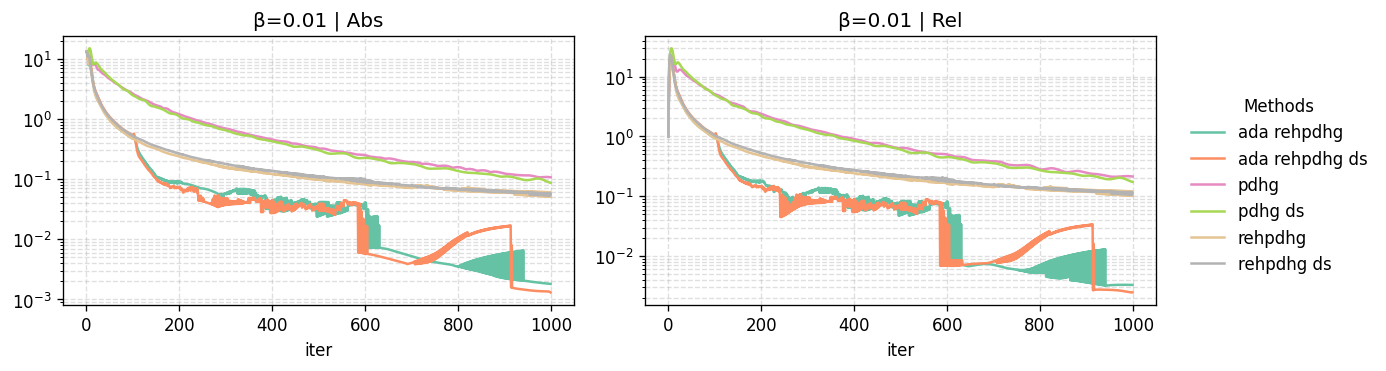

In [28]:
_ = plot_residuals_grid_by_param({beta:residuals}, 
                                #  abs_ylim=(1e-3, 5), rel_ylim=(1e-4, 1.5), 
                                 param_name='beta')

In [13]:
# cupdlp r1 is large probably due to rounding of Y and the corresponding sign(Y) 

#  $m=n=1000$

In [14]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5
A2, A1, G1, G2, A2_np, A1_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)

A_linop = attn_linop_from_matrices(A1, A2)
Grad = torch.cat([G1, G2], dim=0)
lamb_max = A_linop.fro_norm

print(f"{lamb_max=:.4e}")

lamb_max=1.0007e+01


In [15]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}")
    residuals[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-6)

beta=0.001, lamb_max=1.0007e+01
Method                 Obj          Viol
----------------------------------------
pdhg          -9.733663e-01  4.129799e-01
rehpdhg       -9.807405e-01  6.127420e-02
pdhg ds       -9.847102e-01  4.132962e-01
rehpdhg ds    -9.931639e-01  5.903891e-02
ada rehpdhg   -9.644992e-01  6.374209e-02
ada rehpdhg ds  -9.767770e-01  5.490512e-02
beta=0.0005, lamb_max=1.0007e+01
Method                 Obj          Viol
----------------------------------------
pdhg          -4.933851e-01  7.082754e-01
rehpdhg       -5.008919e-01  8.698709e-02
pdhg ds       -4.961668e-01  6.943011e-01
rehpdhg ds    -5.049765e-01  8.090532e-02
ada rehpdhg   -4.921388e-01  6.589147e-02
ada rehpdhg ds  -4.950224e-01  5.170021e-02
beta=0.0001, lamb_max=1.0007e+01
Method                 Obj          Viol
----------------------------------------
pdhg          -9.939627e-02  2.940583e+00
rehpdhg       -1.076273e-01  3.241191e-01
pdhg ds       -9.953074e-02  3.130698e+00
rehpdhg ds    -1.08837

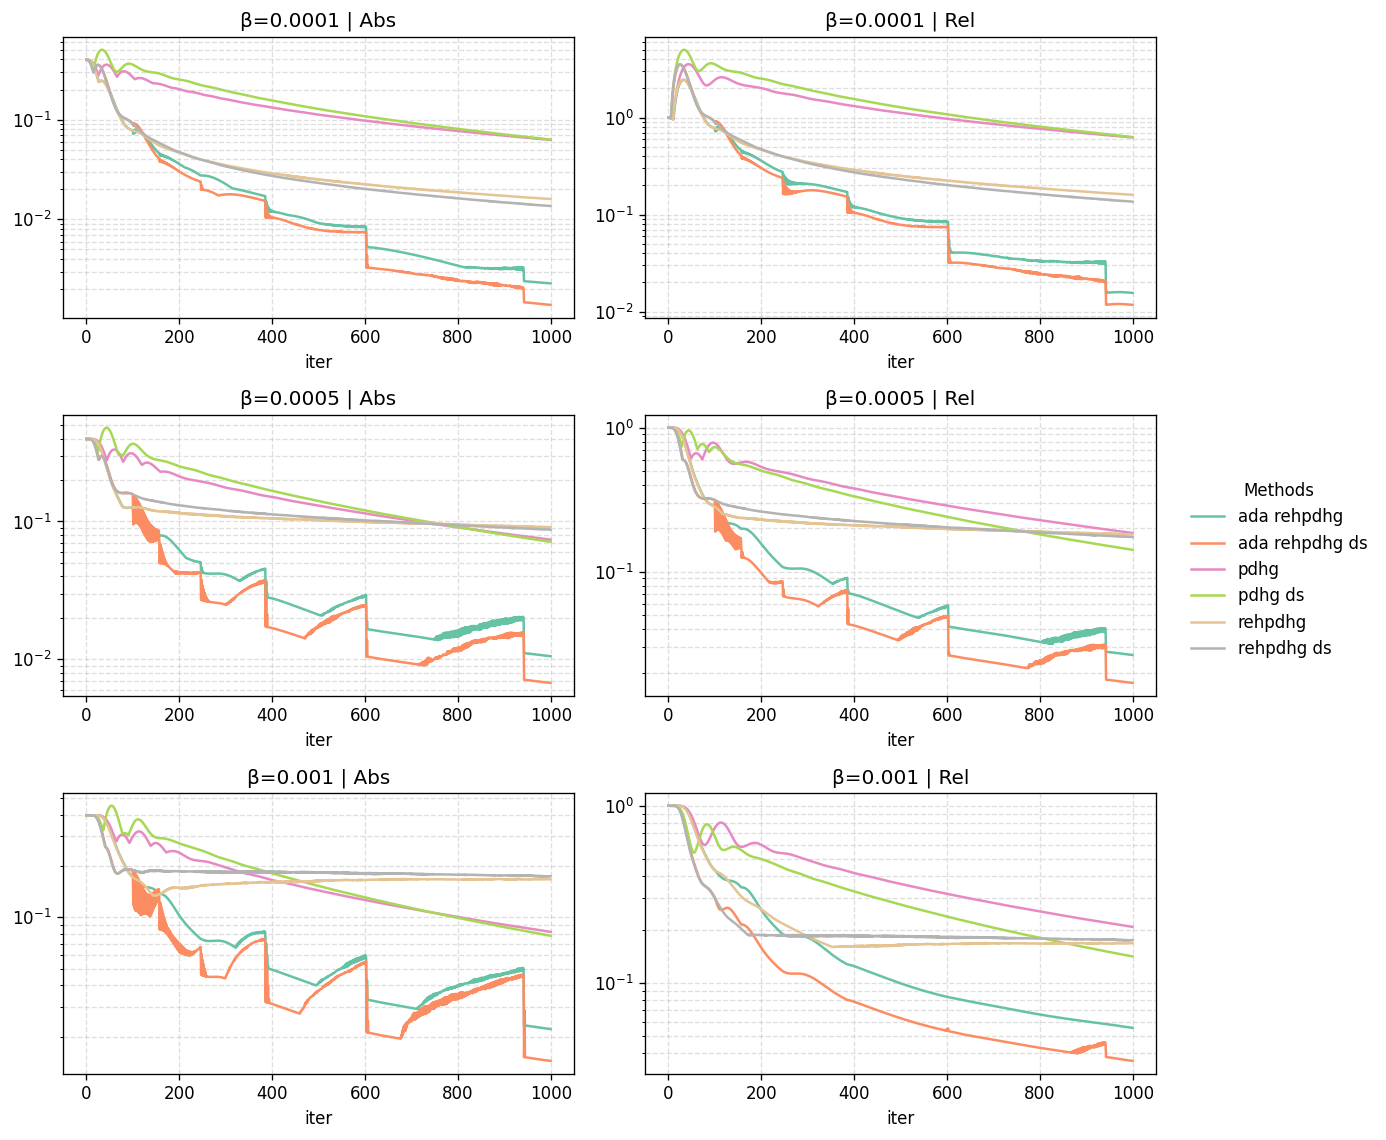

In [16]:
_ = plot_residuals_grid_by_param(residuals, 
                                #  abs_ylim=(1e-3, 5), rel_ylim=(1e-4, 1.5), 
                                 param_name='beta')

#  $m=n=1000$

In [17]:
m = n = 1000
std2 = 0.1

A2, A1, G1, G2, A2_np, A1_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)

A_linop = attn_linop_from_matrices(A1, A2)
Grad = torch.cat([G1, G2], dim=0)
lamb_max = A_linop.fro_norm

print(f"{mu_reg=:.4e}, {lamb_max=:.4e}")

mu_reg=0.0000e+00, lamb_max=9.9972e+00


In [18]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()
 
    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}")
    residuals[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-6)

beta=0.001, lamb_max=9.9972e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -7.851695e-02  9.446584e-02
rehpdhg       -7.858338e-02  3.361032e-02
pdhg ds       -8.680739e-02  8.426018e-02
rehpdhg ds    -8.687731e-02  2.858897e-02
ada rehpdhg   -6.065824e-02  2.158915e-02
ada rehpdhg ds  -7.558116e-02  2.009904e-02
beta=0.0005, lamb_max=9.9972e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -4.410499e-02  1.374202e-01
rehpdhg       -4.418071e-02  4.154786e-02
pdhg ds       -4.644143e-02  1.338174e-01
rehpdhg ds    -4.652164e-02  3.680766e-02
ada rehpdhg   -4.100100e-02  2.876336e-02
ada rehpdhg ds  -4.361166e-02  3.236944e-02
beta=0.0001, lamb_max=9.9972e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -9.730626e-03  4.289512e-01
rehpdhg       -9.805989e-03  6.552805e-02
pdhg ds       -9.847830e-03  4.188573e-01
rehpdhg ds    -9.93091

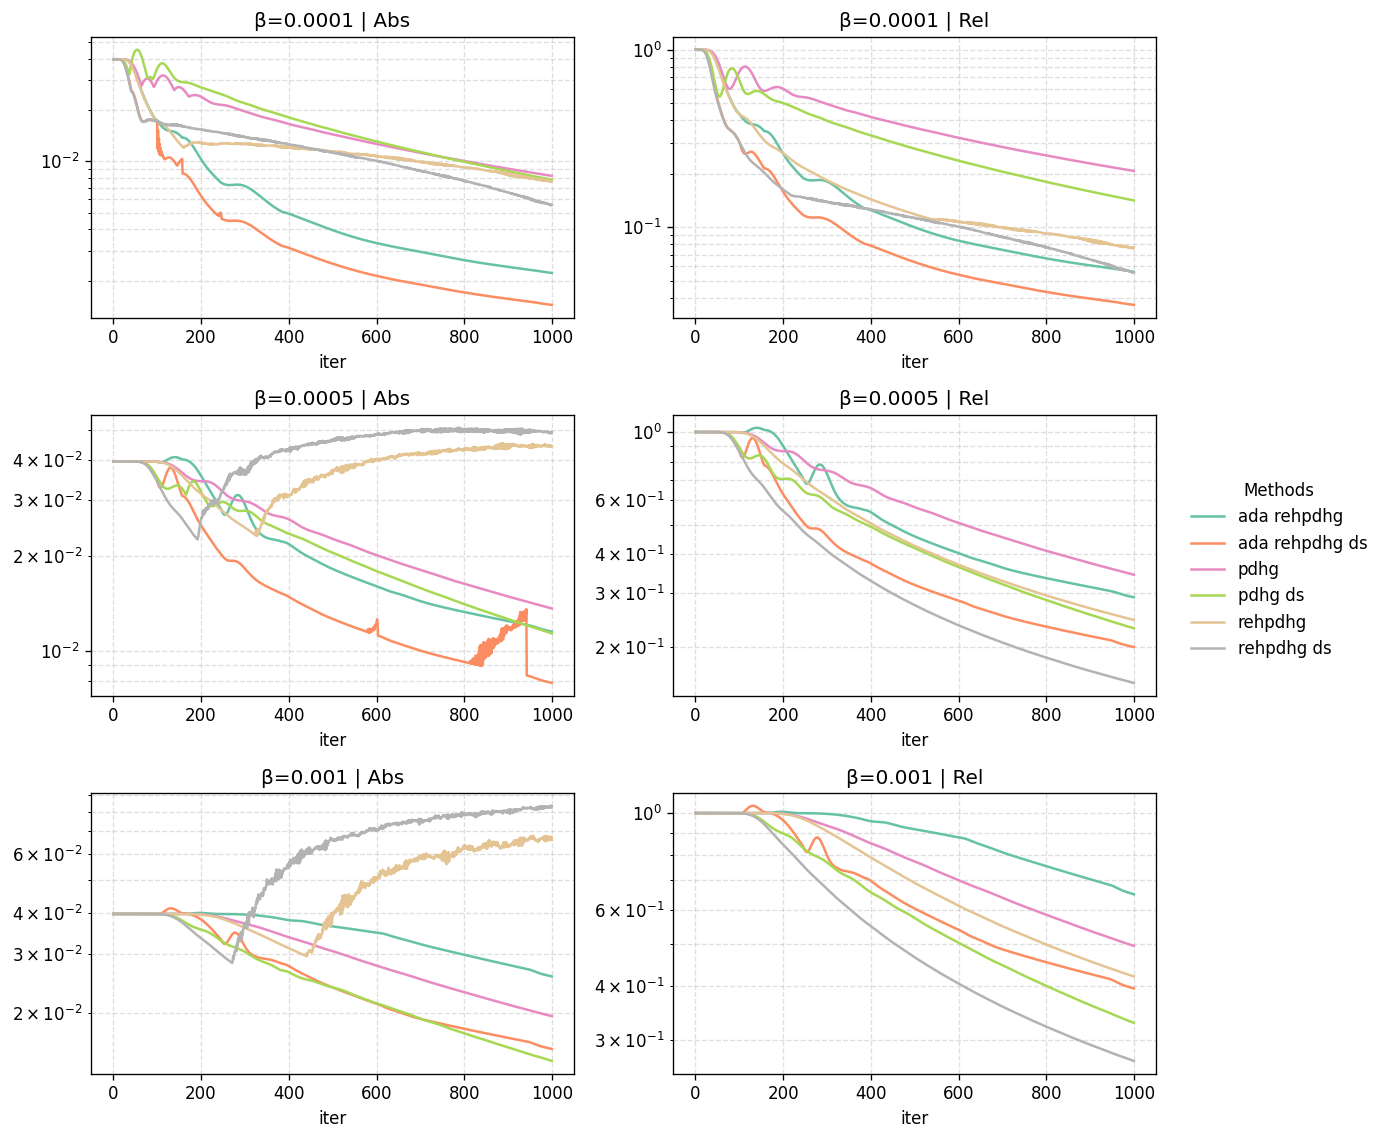

In [19]:
_ = plot_residuals_grid_by_param(residuals,  param_name='beta')